In [1]:
import sklearn
import pandas as pd
import numpy as np
import nltk
import sklearn
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import matplotlib
from sklearn.model_selection import cross_val_score
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.model_selection import train_test_split
import re
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
import pickle
from wordcloud import WordCloud

In [2]:
full_reviewed_data_drop = pd.read_csv('../../input_data/full_datasets/fully_hand_labelled_texts.csv')
indices = pd.read_csv('medrobertanl-haga_smoking_predictions.csv', delimiter=';')

In [3]:
test_set = full_reviewed_data_drop.loc[indices['index']]

In [6]:
test_set_check = test_set[['text', 'Roken']]

In [4]:
test_set.text = test_set.text.str.replace("_x000D_\n", "\t")


In [7]:
test_set_check['Roken'] = test_set_check['Roken'].str.replace('Geen gebruiker', 'Voormalige gebruiker')

<ipython-input-7-8f60690a6cf2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_check['Roken'] = test_set_check['Roken'].str.replace('Geen gebruiker', 'Voormalige gebruiker')


In [9]:
test_set_check = test_set_check[(test_set_check.Roken == 'Huidige gebruiker') | (test_set_check.Roken == 'Voormalige gebruiker')]

In [10]:
test_set_check

,text,Roken
48,Beloop: \tBeloop: Reguliere controle na ACDF C...,Huidige gebruiker
57,Anamnese: \t Verkort consult: Voorgeschiedenis...,Voormalige gebruiker
65,Anamnese: \t Verkort consult: 1987 liesbreuk\t...,Voormalige gebruiker
67,Anamnese: \tIntoxicatiesDe patiÃ«nt rookte en ...,Voormalige gebruiker
71,Anamnese: \t Verkort consult: Aandachtspunten ...,Voormalige gebruiker
...,...,...
4678,Samenvatting: \tVoorgeschiedenis: in verleden ...,Voormalige gebruiker
4682,"Anamnese: \tNog steeds hielspoor links, heeft ...",Voormalige gebruiker
4688,Reden van komst / Verwijzing: \tReden verwijzi...,Voormalige gebruiker
4691,Anamnese: \t Verkort consult: Aandachtspunten ...,Huidige gebruiker


In [12]:
def apply_string_matching(row):
    text = row['text'].lower()
    if "roken+" in text or "roken +" in text:
        return 'Huidige gebruiker'
    if 'door' in text and 'stoppen' in text:
        return 'Voormalige gebruiker'
    if 'gevolg' in text and 'stoppen' in text:
        return 'Voormalige gebruiker'
    if ('gestopt' in text or 'gestaakt' in text) and not ('niet' in text or 'was' in text):
        return 'Voormalige gebruiker'
    if 'tot' in text and 'jaar' in text:
        return 'Voormalige gebruiker'
    if 'roken-' in text or 'roken -' in text:
        return 'Voormalige gebruiker'
    if 'stoppen' in text or 'staken' in text or 'verminderen' in text or 'persisterend' in text:
        return 'Huidige gebruiker'
    if 'per dag' in text or 'packyears' in text or "/dag" in text or "pakje" in text or "pack" in text:
        return "Huidige gebruiker"
    if 'pd' in text or "py" in text:
        return 'Huidige gebruiker'

test_set_check['Prediction'] = test_set_check.apply(lambda row: apply_string_matching(row), axis=1)

<ipython-input-12-5b98bc108d4e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_check['Prediction'] = test_set_check.apply(lambda row: apply_string_matching(row), axis=1)


In [15]:
test_set_check_no_na = test_set_check.dropna()
test_set_check_no_na

,text,Roken,Prediction
48,Beloop: \tBeloop: Reguliere controle na ACDF C...,Huidige gebruiker,Huidige gebruiker
57,Anamnese: \t Verkort consult: Voorgeschiedenis...,Voormalige gebruiker,Huidige gebruiker
65,Anamnese: \t Verkort consult: 1987 liesbreuk\t...,Voormalige gebruiker,Voormalige gebruiker
67,Anamnese: \tIntoxicatiesDe patiÃ«nt rookte en ...,Voormalige gebruiker,Voormalige gebruiker
71,Anamnese: \t Verkort consult: Aandachtspunten ...,Voormalige gebruiker,Voormalige gebruiker
...,...,...,...
4676,Anamnese: \t Vraagstelling: Aanvrager: Feitsma...,Voormalige gebruiker,Voormalige gebruiker
4682,"Anamnese: \tNog steeds hielspoor links, heeft ...",Voormalige gebruiker,Voormalige gebruiker
4688,Reden van komst / Verwijzing: \tReden verwijzi...,Voormalige gebruiker,Voormalige gebruiker
4691,Anamnese: \t Verkort consult: Aandachtspunten ...,Huidige gebruiker,Voormalige gebruiker


0.7704918032786885


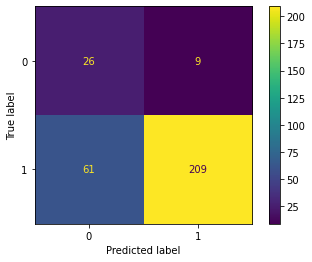

                      precision    recall  f1-score   support

   Huidige gebruiker       0.30      0.74      0.43        35
Voormalige gebruiker       0.96      0.77      0.86       270

            accuracy                           0.77       305
           macro avg       0.63      0.76      0.64       305
        weighted avg       0.88      0.77      0.81       305



In [16]:
print(np.mean(test_set_check_no_na['Prediction'] == test_set_check_no_na['Roken']))
cm = confusion_matrix(test_set_check_no_na['Roken'], test_set_check_no_na['Prediction'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()
print(metrics.classification_report(test_set_check_no_na['Roken'], test_set_check_no_na['Prediction']))